# Regression Demo on Superconductor Dataset
*Work produced by Stephen Toner, Fall 2021*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as os
from sklearn.linear_model import ElasticNet as en
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.metrics import mean_squared_error as mse
import itertools
from IPython.core.display import display, HTML

We are analyzing data from the University of California Irvine
[superconductor](https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data)
dataset that includes the physical properties of different superconductors,
one of which is the critical point of the superconductor. We wish to estimate
the critical point of a substance based on its other physical properties 
using three different machine learning methods: Elastic Net, 
Random Forests, and Gradient Boosting.

## Data Prep

We begin by reading the data and segmenting it into training, validation,
and testing subsets,

In [2]:
train = pd.read_csv("train.csv")

x_total = train.iloc[:,:-1]
y_total = train.iloc[:,-1]

n_samples = len(y_total) # 

idx = np.arange(len(y_total))

# Initialize random number generator
rng = np.random.default_rng(11 * 19 + 2021)
np.random.shuffle(idx)

n_train = int(n_samples * .8 // 1)
n_test = int(n_samples * .1 // 1)
n_val = n_samples - n_test - n_train

train_idx = idx[0:n_train]
test_idx = idx[n_train:(n_train + n_test)]
val_idx = idx[(n_train + n_test):(n_train + n_test+n_val)]

x_train = x_total.iloc[train_idx].to_numpy()
y_train = y_total.iloc[train_idx].to_numpy()

x_test = x_total.iloc[test_idx].to_numpy()
y_test = y_total.iloc[test_idx].to_numpy()

x_val = x_total.iloc[val_idx].to_numpy()
y_val = y_total.iloc[val_idx].to_numpy()

folds = np.array_split(np.arange(len(x_val)),10) # Previously randomized, no need to shuffle

## Training and Tuning Models

As we train and tune the first pass of the models using a cross validation /
grid search approach, we will use the functions below to explore different 
combinations of hyperparameters. As this can take some time, we will save the
resulting errors for each model to the working directory so we can quickly
load it again in the future.

In [3]:
def param_product(**kwargs):
    """
    Returns a generator of dictionaries for all combinations of values 
    for each tuning parameter passed. For instance, if you were
    to pass C = [1, 5] and max_iter = [1, 10], the generator would 
    return dicts of {C: 1, max_iter : 1}, {C: 1, max_iter : 10}, etc.

    Parameters
    ----------
    **kwargs : Dict of Lists
        A dictionary where each key represents a tuning parameter, and
        the corresponding value is a list of values to set for the
        tuning parameters

    Yields
    ------
    Generator of dictionaries
        Each dictionary can subsequently be passed to the sklearn
        model's **kwargs parameter

    """    
    keys = kwargs.keys()
    vals = kwargs.values()
    for elt in itertools.product(*vals):
        yield dict(zip(keys,elt))
    
        
def gen_label(dict_item):
    """
    Helper function for param_product. creates a unique string to
    act as the key for a given combination of tuning parameters
    to be stored in the errors / avg_errors dictionary in
    cross_validate

    Parameters
    ----------
    dict_item : 
        A single dictionary returned from the param_product
        generator. Should only have one parameter value for each key

    Returns
    -------
    String
        Unique space-delimited string for the given combination of 
        tuning parameters / values
    """
    label = []
    for k, v in dict_item.items():
        for i in[k, str(v)]:
            label.append(i)
    return " ".join(label)
    
def cross_validate(name, k_folds, param_space, train, labels):
    """
    Performs k-fold cross validation across param_space
    
    Parameters
    ----------
    name : string
        Model to be used for cross validtion. Can be 
          - "en" => ElasticNet
          - "rfr" => RandomForestRegressor
          - "gbr" => GradientBoostingRegressor
    k_folds : 
        List of lists, each corresponding ot the indices of the different
        folds in train with which to perform cross validation. Should already
        be randomized before function call
    param_space : Dictionary
        Dictionary where keys correspond to tuning parameters, and values
        are lists of values to set for each pass of cross validation
    train : ndarray
        training data with which to perform cross validation
    labels : ndarray (vector, n x 1)
        labels for training data to measure mse

    Returns 
    -------
    avg_errors() (list of tuples)
        unpacks results from cross validation, returning 
        a list of tuples where the first value is the unique
        string of model training parameters, and the second value
        is the resulting MSE. Sorts in ascending order by loss measure

    """
    errors = {}
    avg_errors = {}
    loss = mse
    params = param_product(**param_space)
    for p in params:

        p_label = gen_label(p)
        errors[p_label] = []
        if name == "en": # Elastic Net
            model = en(max_iter = 50000, tol=.001, warm_start=True, **p)
        elif name =="rf": # Random Forest
            model =rfr(n_jobs = 2, **p)
        elif name =="gbr": # Gradient Boosted Regressor
            model = gbr(**p)
        else:
            break
        for k in k_folds:
            # Segment out the validation set
            mask = np.ones(len(train), dtype=bool)
            mask[k] = False
            i_train = train[mask]
            i_tr_labels = labels[mask]
            i_test = train[k]
            i_t_labels = labels[k]
            # Train and Estimate holdout error
            model_f = model.fit(i_train, i_tr_labels)
            pred = model_f.predict(i_test)
            errors[p_label].append(loss(i_t_labels, pred))
            
        avg_errors[p_label] = np.mean(errors[p_label])
    return sorted(list(avg_errors.items()),key=lambda x: x[1])

### Elastic Net ### 
Elastic Net is a hybrid between two of the most popular regularized
regression methods in machine learning, ridge regression and 
lasso regression. The fundamental approach for both methods is the same,
but they differ in their regularization term.

The form of ridge regression is 
$$ F_{ridge}(\mathbf{w}) = \sum ^n _{j = 1} (y_j - \hat y_j (\mathbf{w}))^2 + 
\lambda \sum_{i=1}^p \|w_i\|_2^2 $$

While lasso regression has the form 
$$ F_{lasso}(\mathbf{w}) = \sum ^n _{j = 1} (y_j - \hat y_j (\mathbf{w}))^2 + 
\lambda \sum_{i=1}^p |w_i|_1 $$

Elastic Net uses a linear combination of the L2 and L1 penalties used
by ridge and lasso regression, respectively.

The two parameters we will be sensitizing over are alpha and l1_ratio:
+ alpha: Coefficient for the penalty terms, determines how much the model
tries to keep the magnitude of the weights small
+ l1_ratio: Specifies the proportion of the penalty terms that are L1 vs. L2
Below we conduct a grid search, where we have a range of values for each
hyperparameter and explore all combinations of values for each hyperparameter.

The ranges for the grid search below were based on trial-and-error to see
that a given set of inputs did not result in weak duality.

In [4]:
# alpha 
alpha_space = [0.2, 0.4, 0.6, 0.8]

# l1_ratio
l1_space = np.linspace(0,1,5)[1:] # Omit zero

en_parameters = {
            "alpha" : alpha_space,
            "l1_ratio" : l1_space
    }

Now we perfrom 10-fold cross validation, a process where we omit one tenth
of the data at a time (the omitted data is called a fold), train the 
algorithm on the remaining  90% of the data, and then evaluate against the
omitted fold. This helps us prevent overfitting to some specific feature or
to a specific cohort of observations.

In [5]:
en_filename = "EnetErrors.pkl"

if(os.exists(en_filename)):
    en_df = pd.read_pickle(en_filename)
else:
    en_errors = cross_validate("en", folds, en_parameters, x_train, y_train)
    en_df = pd.DataFrame(en_errors, columns =["String", "MSE"])
    en_df["alpha"] = en_df["String"].str.split("alpha|l1_ratio", expand=True)[1]
    en_df["l1"] = en_df["String"].str.split("alpha|l1_ratio", expand=True)[2]
    en_df.to_pickle(en_filename) 

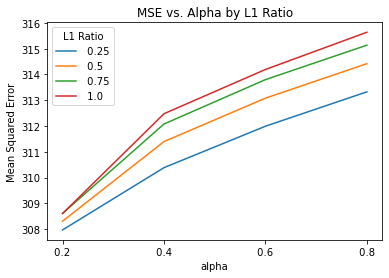

L1 Ratio,0.25,0.5,0.75,1.0
alpha,,,,
0.2,307.97,308.30,308.61,308.60
0.4,310.38,311.39,312.08,312.48
0.6,311.99,313.08,313.80,314.19
0.8,313.33,314.42,315.14,315.64


In [6]:
fig, ax = plt.subplots()
for k, g in en_df.groupby(["l1"]):
    ax.plot(g["alpha"], g["MSE"], label = k)

ax.set_xlabel("alpha")
ax.set_ylabel("Mean Squared Error")
ax.set_title("MSE vs. Alpha by L1 Ratio")
plt.legend(loc='best', title ="L1 Ratio")
plt.show()


en_df = en_df.rename(columns={"l1": "L1 Ratio"})
en_table = en_df.pivot("alpha", "L1 Ratio", "MSE")

display(HTML(en_table.to_html(index= True, 
                                 float_format = lambda x: "%10.2f" % x)))    


Comments: Generally speaking MSE is an increasing function of alpha and l1.
This means that we have many features that we need to make use of in order
to make a good prediction (low alpha) and that Ridge is outperforming Lasso
regression in this particular case (low l1 ratio)

### Random Forest ###

The name "Random Forest" comes from the fact that this method creates 
a "forest" of decision trees in order to predict an outcome, in this case
a regression value. The use of many randomly selected decision trees helps
mitigate the tendency for decision trees to overfit, and allows for greater
model stability and accuracy.

Tuning Parameters
+ n_estimators: Number of trees in the forest
+ max_depth: Maximum allowable depth for a given tree

In [7]:
n_est_space = [10, 50, 100] 
depth_space = [3, 6, 9, 12]

rfr_parameters = {
            "n_estimators" : n_est_space,
            "max_depth" : depth_space
    }

Next we cross validate again:

In [8]:
rfr_filename = "RfErrors.pkl"

if(os.exists(rfr_filename)):
    rfr_df = pd.read_pickle(rfr_filename)
else:
    rfr_errors = cross_validate("rf", folds, rfr_parameters, x_train, y_train)
    rfr_df = pd.DataFrame(rfr_errors, columns =["String", "MSE"])

    rfr_df["n_estimators"] = rfr_df["String"].str.split("n_estimators|max_depth", 
                                                  expand=True)[1]
    rfr_df["max_depth"] = rfr_df["String"].str.split("n_estimators|max_depth", 
                                                  expand=True)[2]
    rfr_df.to_pickle(rfr_filename) 

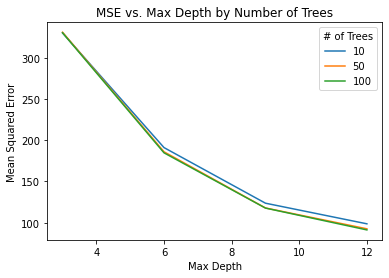

Max Depth,3,6,9,12
Number of Trees,,,,
10,329.99,191.03,123.62,98.62
50,330.84,185.93,117.83,92.58
100,330.21,184.67,117.70,91.23


In [9]:
rfr_df["num_estimators"] = pd.to_numeric(rfr_df["n_estimators"])
rfr_df["max_depth"] = pd.to_numeric(rfr_df["max_depth"])
fig, ax = plt.subplots()
for k, g in rfr_df.groupby(["num_estimators"]):
    ax.plot(g["max_depth"], g["MSE"], label = k)
ax.set_xlabel("Max Depth")
ax.set_ylabel("Mean Squared Error")
ax.set_title("MSE vs. Max Depth by Number of Trees")
plt.legend(loc='best', title ="# of Trees")
plt.show()

rfr_df = rfr_df.rename(columns={"num_estimators": "Number of Trees",
                                "max_depth": "Max Depth"})
rfr_table = rfr_df.pivot("Number of Trees", "Max Depth", "MSE")

display(HTML(rfr_table.to_html(index= True, 
                                 float_format = lambda x: "%10.2f" % x)))    

Comments:
+ The random forest method achieves (in general) a much lower MSE than
the previous Elastic Net method
+ Increasing the number of trees and the maximum depth of each tree 
improved model accuracy and reduced mean squared error

### Gradient Boosting Regression ###

The last class of model we will use is an example of an ensemble method,
where a base learner takes an input of weights corresponding to a set
of learning models, and determines the weight of each model's output so as
to approximately minimize empirical risk.

Parameters
+ Boosting Rounds: Number boosting rounds (sub-models) to construct
+ Learning Rate: Each model has progressively less and less impact on the 
final output; learning rate determines how much each subsequent model's 
influence is reduced

In [10]:
learning_rate_space = [0.1, 0.2, 0.3, 0.4, 0.5]
n_est_space = [3, 10, 15, 50, 100]
gbr_parameters = {"learning_rate" : learning_rate_space,
                    "n_estimators" : n_est_space}

A final round of cross validation for gradient boosting:

In [11]:
gbr_filename = "GBRErrors.pkl"

if(os.exists(gbr_filename)):
    gbr_df = pd.read_pickle(gbr_filename)
else:
    gbr_errors = cross_validate("gbr", folds, gbr_parameters, x_train, y_train)
    gbr_df = pd.DataFrame(gbr_errors, columns =["String", "MSE"])

    gbr_df["learning_rate"] = gbr_df["String"].str.split("learning_rate|n_estimators", 
                                                  expand=True)[1]
    gbr_df["n_estimators"] = gbr_df["String"].str.split("learning_rate|n_estimators", 
                                                  expand=True)[2]
    gbr_df.to_pickle(gbr_filename) 

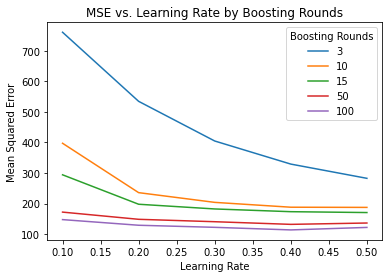

Learning Rate,0.1,0.2,0.3,0.4,0.5
Boosting Rounds,,,,,
3,760.66,534.54,404.73,329.16,282.58
10,397.34,235.72,203.89,188.04,187.46
15,294.13,197.76,182.34,173.41,170.58
50,172.02,148.46,140.58,131.92,136.33
100,147.48,129.02,122.22,113.75,121.94


In [12]:
gbr_df["num_estimators"] = pd.to_numeric(gbr_df["n_estimators"])
gbr_df["learning_rate"] = pd.to_numeric(gbr_df["learning_rate"])

gbr_df = gbr_df.sort_values(["num_estimators", "learning_rate"])

fig, ax = plt.subplots()
for k, g in gbr_df.groupby(["num_estimators"]):
    ax.plot(g["learning_rate"], g["MSE"], label = k)
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Mean Squared Error")
ax.set_title("MSE vs. Learning Rate by Boosting Rounds")
plt.legend(loc='best', title ="Boosting Rounds")
plt.show()

gbr_df = gbr_df.rename(columns={"num_estimators": "Boosting Rounds",
                                "learning_rate" : "Learning Rate"})
gbr_table = gbr_df.pivot("Boosting Rounds", "Learning Rate", "MSE")

display(HTML(gbr_table.to_html(index= True, 
                                 float_format = lambda x: "%10.2f" % x)))   

As one might expect, increasing the number of boosting rounds lowered MSE.
The best choice of learning rate was 0.4, which suggests that some of the
models learned in the final boosting rounds were being discounted too much
when learning rate was set to 0.5

## Validation and Testing ##
After we've tuned our hyperparameters, we need to choose which one of these 
models will be used against the test set. We can achieve this by taking the
hyperparameters with the best performance against the training data and
see how models with these parameters perform on the validation set.

In [13]:
# Final Elastic Net
opt_en = en(alpha=0.2,l1_ratio=.25, max_iter = 50000, tol=.001)
opt_en_f = opt_en.fit(x_train,y_train)

# Final Random Forest
opt_rfr = rfr(100,max_depth = 12)
opt_rfr_f = opt_rfr.fit(x_train,y_train)

# Final Gradient Boosting Regressor
opt_gbr = gbr(n_estimators = 100, learning_rate = 0.4)
opt_gbr_f = opt_gbr.fit(x_train,y_train)

# Evaluate three models against the validation dataset
pred_v_en = opt_en_f.predict(x_val)
pred_v_rfr = opt_rfr_f.predict(x_val)
pred_v_gbr = opt_gbr_f.predict(x_val)

val_err_en = mse(y_val, pred_v_en)
val_err_rfr = mse(y_val, pred_v_rfr)
val_err_gbr = mse(y_val, pred_v_gbr)

# Table with output (MSE)
models = ["Elastic Net", "Random Forest", "Gradient Boosting"]
errors = [val_err_en, val_err_rfr, val_err_gbr]

v_table = pd.DataFrame(data = models)
v_table = v_table.rename(columns={0:"Model"})
v_table["MSE"] = errors
v_table = v_table.sort_values("MSE")

display(HTML(v_table.to_html(index= False, 
                                 float_format = lambda x: "%10.2f" % x)))    

Model,MSE
Random Forest,101.92
Gradient Boosting,127.03
Elastic Net,314.76


It seems that based on mean squared error alone, our random forest regression
was the best learning method for predicting superconductivity.

Now for the moment of truth: assessing predictions for the test data.

In [14]:
pred_t = opt_rfr_f.predict(x_test)
final_error = mse(y_test, pred_t)
output_msg = "The final MSE for the best model on the test data is {0:0.1f}"
print(output_msg.format(final_error))

The final MSE for the best model on the test data is 112.7


Our model has a relatively low MSE, suggesting it is decently well trained.